In [117]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.layers import Conv2D,UpSampling2D,MaxPooling2D, Input, Flatten, Dense, Dropout, BatchNormalization

In [118]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

print(tf.__version__)

2.3.0


In [161]:
dataset = pd.read_csv("ZY set.csv",index_col=0)
test = pd.read_csv("ZY test set.csv",index_col=0)

In [163]:
dataset.head()

,retweet_count,favorite_count,is_retweet,hashtag_count,mention_count,word_count,char_count,word_density,punctuation_freq,upper_case_freq,...,54,55,56,57,58,59,60,61,62,63
market_date,,,,,,,,,,,,,,,,,,,,,
2016-01-04,2660.326087,6782.043478,0.021739,0.369565,0.847826,25.434783,125.586957,5.041834,0.264225,0.040537,...,-0.017944,0.104394,0.075825,-0.092878,-0.024292,-0.058247,-0.044973,0.028491,-0.181183,0.054244
2016-01-05,1311.800000,3935.666667,0.000000,0.200000,1.933333,23.933333,125.066667,5.315622,0.369321,0.068486,...,0.010007,0.120056,0.097633,-0.081707,-0.043652,-0.079861,-0.050876,-0.000848,-0.194857,0.077745
2016-01-06,2070.187500,5250.812500,0.000000,0.187500,1.812500,22.312500,115.125000,5.171109,0.328001,0.049176,...,0.000862,0.108198,0.062387,-0.120868,-0.012046,-0.101719,-0.050537,0.028487,-0.173961,0.071916
2016-01-07,2320.153846,4770.153846,0.076923,0.000000,0.615385,24.307692,119.384615,4.932159,0.196628,0.061658,...,0.016458,0.062872,0.096209,-0.116414,-0.040070,-0.039273,-0.037580,0.042244,-0.169883,0.053672
2016-01-08,1755.272727,5410.545455,0.000000,0.181818,1.272727,21.090909,103.000000,4.857924,0.233505,0.023726,...,0.011105,0.133338,0.113586,-0.117101,-0.046171,-0.057523,-0.045804,-0.004404,-0.201545,0.091630


In [164]:
test.head()

,retweet_count,favorite_count,is_retweet,hashtag_count,mention_count,word_count,char_count,word_density,punctuation_freq,upper_case_freq,...,54,55,56,57,58,59,60,61,62,63
market_date,,,,,,,,,,,,,,,,,,,,,
2020-10-01,34830.333333,216241.000000,0.000000,0.333333,0.000000,14.666667,69.333333,4.405556,0.191667,0.250000,...,0.010593,0.130864,0.096210,-0.014320,-0.039816,-0.092404,-0.068976,-0.008147,-0.211419,0.100159
2020-10-02,23461.477273,58863.386364,0.840909,0.022727,0.295455,19.568182,106.022727,5.392871,0.216006,0.080107,...,0.018224,0.049644,0.090730,-0.114625,-0.010032,-0.056911,-0.057783,0.050584,-0.163385,0.044907
2020-10-05,52996.437500,296731.781250,0.125000,0.093750,0.156250,20.562500,102.687500,4.813073,0.272551,0.376988,...,-0.000669,0.117264,0.066918,-0.064577,0.000650,-0.080865,-0.050203,0.039510,-0.197192,0.039019
2020-10-06,32445.666667,165082.857143,0.000000,0.000000,0.238095,38.761905,198.333333,4.953241,0.190124,0.131421,...,0.000649,0.092569,0.095646,-0.085586,-0.023837,-0.054720,-0.044865,0.004891,-0.197438,0.051640
2020-10-07,23030.730769,49591.557692,0.548077,0.134615,0.192308,23.250000,122.538462,5.212676,0.210228,0.122730,...,0.010200,0.046346,0.075819,-0.122187,-0.018855,-0.052574,-0.062234,0.054490,-0.179098,0.016661


In [121]:
dataset.columns

Index(['retweet_count', 'favorite_count', 'is_retweet', 'hashtag_count',
       'mention_count', 'word_count', 'char_count', 'word_density',
       'punctuation_freq', 'upper_case_freq', '^GSPC', '^IXIC', 'VGT',
       'topic1', 'topic2', 'topic3', 'topic4', 'topic5', 'topic6', 'topic7',
       'topic8', 'topic9', 'topic10', '0', '1', '2', '3', '4', '5', '6', '7',
       '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19',
       '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31',
       '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43',
       '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55',
       '56', '57', '58', '59', '60', '61', '62', '63'],
      dtype='object')

In [165]:
#Stock market prices
y = dataset.iloc[:,10:13]
y_test = test.iloc[:,10:13]

#Rearrange so stock market prices are at the end
dataset = dataset.iloc[:,np.r_[:10,13:len(dataset.columns)]]
dataset = pd.concat([dataset,y],axis=1)

test = test.iloc[:,np.r_[:10,13:len(test.columns)]]
test = pd.concat([test,y_test],axis=1)
dataset.head()

,retweet_count,favorite_count,is_retweet,hashtag_count,mention_count,word_count,char_count,word_density,punctuation_freq,upper_case_freq,...,57,58,59,60,61,62,63,^GSPC,^IXIC,VGT
market_date,,,,,,,,,,,,,,,,,,,,,
2016-01-04,2660.326087,6782.043478,0.021739,0.369565,0.847826,25.434783,125.586957,5.041834,0.264225,0.040537,...,-0.092878,-0.024292,-0.058247,-0.044973,0.028491,-0.181183,0.054244,2012.660034,4903.089844,100.618843
2016-01-05,1311.800000,3935.666667,0.000000,0.200000,1.933333,23.933333,125.066667,5.315622,0.369321,0.068486,...,-0.081707,-0.043652,-0.079861,-0.050876,-0.000848,-0.194857,0.077745,2016.709961,4891.430176,100.137505
2016-01-06,2070.187500,5250.812500,0.000000,0.187500,1.812500,22.312500,115.125000,5.171109,0.328001,0.049176,...,-0.120868,-0.012046,-0.101719,-0.050537,0.028487,-0.173961,0.071916,1990.260010,4835.759766,98.778427
2016-01-07,2320.153846,4770.153846,0.076923,0.000000,0.615385,24.307692,119.384615,4.932159,0.196628,0.061658,...,-0.116414,-0.040070,-0.039273,-0.037580,0.042244,-0.169883,0.053672,1943.089966,4689.430176,95.597809
2016-01-08,1755.272727,5410.545455,0.000000,0.181818,1.272727,21.090909,103.000000,4.857924,0.233505,0.023726,...,-0.117101,-0.046171,-0.057523,-0.045804,-0.004404,-0.201545,0.091630,1922.030029,4643.629883,94.776695


### train-test split

In [123]:
train_dataset = dataset.sample(frac=0.75, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

#### predict GSPC

In [125]:
train_feature = train_dataset.iloc[:,:-3].copy()
test_feature = test_dataset.iloc[:,:-3].copy()

train_gspc = train_dataset['^GSPC']
test_gspc = test_dataset['^GSPC']

In [126]:
train_feature

,retweet_count,favorite_count,is_retweet,hashtag_count,mention_count,word_count,char_count,word_density,punctuation_freq,upper_case_freq,...,54,55,56,57,58,59,60,61,62,63
market_date,,,,,,,,,,,,,,,,,,,,,
2019-05-10,10719.357143,37912.190476,0.000000,0.000000,0.190476,37.261905,195.261905,5.277689,0.174045,0.047063,...,0.004930,0.060488,0.061357,-0.120131,-0.023096,-0.042284,-0.058552,0.031299,-0.177001,0.058784
2018-04-19,13649.900000,58518.700000,0.100000,0.300000,1.000000,30.400000,171.800000,5.730311,0.193687,0.049240,...,0.031333,0.138005,0.065698,-0.140691,0.032219,-0.098025,-0.068693,0.017239,-0.133172,0.028903
2019-10-25,14697.100000,34956.750000,0.000000,0.050000,0.500000,34.650000,183.500000,5.421858,0.186293,0.048752,...,0.000431,0.043647,0.092263,-0.136549,-0.005516,-0.065343,-0.080538,0.048815,-0.181037,-0.001925
2019-09-17,12048.863636,39756.863636,0.000000,0.227273,0.409091,25.909091,136.090909,5.423615,0.182792,0.072996,...,0.055528,0.098555,0.049272,-0.087630,0.010655,-0.089670,-0.053215,0.021621,-0.179488,0.042504
2017-06-16,24525.428571,101453.571429,0.000000,0.428571,0.428571,20.285714,102.571429,6.027193,0.255552,0.062443,...,0.043311,0.079596,0.047680,-0.032961,-0.029269,-0.013370,-0.018417,0.005554,-0.145150,0.008310
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-08-26,8950.421053,22260.210526,0.000000,0.157895,0.368421,20.315789,113.315789,5.669092,0.240888,0.062383,...,-0.012737,0.074143,0.082612,-0.106673,-0.013199,-0.071373,-0.040022,0.079723,-0.182173,0.051119
2016-06-06,6964.772727,18037.454545,0.090909,0.363636,0.363636,21.272727,108.863636,5.167805,0.183602,0.045413,...,0.005322,0.085896,0.082546,-0.098326,-0.027543,-0.056414,-0.026903,0.005200,-0.193717,0.070208
2016-01-27,4053.444444,11585.444444,0.000000,0.555556,0.222222,18.000000,95.666667,5.580489,0.248560,0.042008,...,0.039942,0.082271,0.090642,-0.081841,-0.049391,-0.063068,-0.042646,0.017201,-0.173208,0.044521


In [129]:
# normalise
normalizer = preprocessing.Normalization(input_shape=[84,])
normalizer.adapt(np.array(train_feature))

In [211]:
stopper = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=10,
    verbose=0,
    mode="min",
    baseline=None,
    restore_best_weights=False,
  )
# create model
def build_and_compile_model(norm):
    model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

    model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
    return model

dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_2 (Normalizati (None, 84)                169       
_________________________________________________________________
dense_51 (Dense)             (None, 64)                5440      
_________________________________________________________________
dense_52 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_53 (Dense)             (None, 1)                 65        
Total params: 9,834
Trainable params: 9,665
Non-trainable params: 169
_________________________________________________________________


In [213]:
history = dnn_model.fit(
    train_feature, train_gspc,
    validation_split=0.2,
    verbose=0, epochs=400,
    callbacks=[stopper])

In [214]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, 2000])
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)

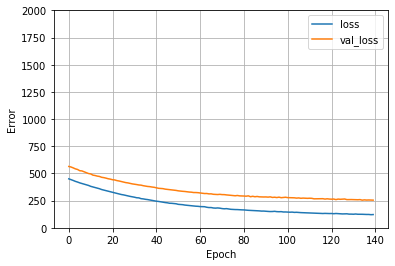

In [215]:
plot_loss(history)

In [216]:
# retrieve the MAPE on the test set

def percentage_error(actual, predicted):
    res = np.empty(actual.shape)
    for j in range(actual.shape[0]):
        if actual[j] != 0:
            res[j] = (actual[j] - predicted[j]) / actual[j]
        else:
            res[j] = predicted[j] / np.mean(actual)
    return res

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs(percentage_error(np.asarray(y_true), np.asarray(y_pred)))) * 100

mean_absolute_percentage_error(test_gspc, dnn_model.predict(test_feature)) #MAPE

9.630543774275448

In [217]:
# RMSE
sqrt(mean_squared_error(dnn_model.predict(test_feature), test_gspc))

367.7301467354653

#### predict IXIC

In [219]:
train_ixic = train_dataset['^IXIC']
test_ixic = test_dataset['^IXIC']

In [220]:
history_ixic = dnn_model.fit(
    train_feature, train_ixic,
    validation_split=0.2,
    verbose=0, epochs=500,callbacks=[stopper])

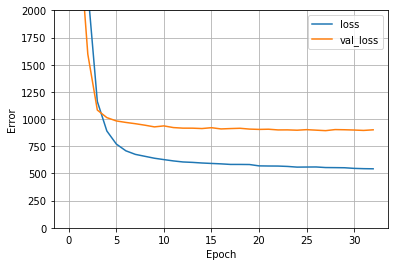

In [221]:
plot_loss(history_ixic)

In [222]:
#MAPE
mean_absolute_percentage_error(test_ixic, dnn_model.predict(test_feature)) 

13.017857712445737

In [223]:
# RMSE
sqrt(mean_squared_error(dnn_model.predict(test_feature), test_ixic))

1326.5581657875393

#### predict VGT

In [224]:
train_vgt = train_dataset['VGT']
test_vgt = test_dataset['VGT']

In [225]:
history_vgt = dnn_model.fit(
    train_feature, train_vgt,
    validation_split=0.2,
    verbose=0, epochs=500,callbacks=[stopper])

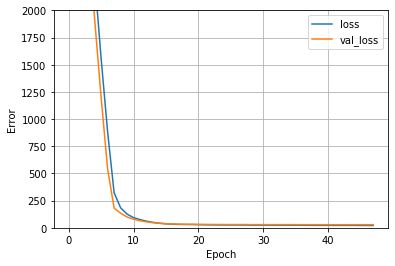

In [226]:
plot_loss(history_vgt)

In [228]:
mean_absolute_percentage_error(test_vgt, dnn_model.predict(test_feature)) #MAPE

18.585568473827152

In [229]:
# RMSE
sqrt(mean_squared_error(dnn_model.predict(test_feature), test_vgt))

43.69192410802111